# 🔷 **Previsão de Churn em Serviços de Telecom** 🔷
---
### 🔵 **Discente(s):**
- 🗿 Bruno Antonio dos Santos Bezerra

- 🗿 Erick Vinicius Rebouças Cruz

- 🗿 Gabriel Monteiro Silva
---
### 🔵 **Framework:**
- ⏫ TensorFlow 2.19.0

- ⏫ Keras 3.9.0
---
### 🔵 **Requerimentos:**
1. Python 3.12.3

1. Tensorflow 2.19.0

1. Pandas 2.2.3

1. Matplotlib 3.10.1

1. Sklearn 1.6.1

1. Numpy 2.1.3

1. Dataset: Last update: Feb27th, 2025
    - https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services/data
---
### 🔵 **Etapas do Projeto:**
- Verificação do uso da GPU

1. Importação de Bibliotecas e Dados

1. Carregamento e Exploração dos Dados

1. Pré-processamento
    1. Retirada de Duplicatas

    1. Retirada de Valores Faltantes

    1. Transformação para Indicadores

    1. Separação dos Conjuntos de Dados

1. Otimização de Hiperparâmetros com Optuna
    1. Modelo MLP

    1. Modelo Random Forest

    1. Modelo Gradient Boosting

    1. Modelo KANs ::TODO::

    1. Modelo STab ::TODO::

    1. Modelo KAN TabKANet ::TODO::

1. Previsões ::TODO::

1. TODO
    - AJEITAR BANCO DE DADOS TREINAMENTO
    - KAN
    - STAB
    - KAN TABKANET
    - AJUSTAR AS METRICAS NO OPTUNA
    - ANEXAR METRICA NO DATASET
---

# 1. Importação de Bibliotecas e Dados

In [9]:
import tensorflow as tf
import joblib
import numpy as np # Manipulação de dados numéricos e estruturados.
import pandas as pd
import matplotlib.pyplot as plt # Geração de gráficos.
import optuna # Otimização de hiperparâmetros.
from sklearn.preprocessing import StandardScaler # Normalização dos dados.
from sklearn.preprocessing import OneHotEncoder # Codificação de variáveis categóricas.
from sklearn.model_selection import StratifiedKFold as SKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# MSE - Erro Médio Quadrático
from sklearn.metrics import mean_squared_error 
# Matriz de Confusão
from sklearn.metrics import confusion_matrix
# AUROC - Área sob a Curva ROC
from sklearn.metrics import roc_auc_score
# Recall, Precision e F1-Score
from sklearn.metrics import recall_score, precision_score, f1_score
# Teste Kolmogorov-Smirnov
from sklearn.metrics import roc_curve
# Modelo MLP
from sklearn.neural_network import MLPClassifier
# Modelo Random Forest
from sklearn.ensemble import RandomForestClassifier
# Modelo Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# Modelo KAN
from imodelsx import KANClassifier

# Importando o tqdm para adicionar barras de progresso
from tqdm import tqdm

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)


# Verificação do uso da GPU

In [10]:
tf.device('/GPU:0')
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(device)
tf.config.list_physical_devices('GPU')

/CPU:0


[]

# 2. Carregamento e Exploração dos Dados

In [11]:
df_original = pd.read_csv('data/customer_churn_telecom_services.csv')
df = df_original
print("Database's shape:", df.shape)
df.head()

Database's shape: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1936.30,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,107.70,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1903.50,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,141.40,Yes


Resumo estatístico para números:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.581350
std,0.368612,24.559481,30.090047,2264.729447
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,394.000000
50%,0.000000,29.000000,70.350000,1393.600000
75%,0.000000,55.000000,89.850000,3786.100000
max,1.000000,72.000000,118.750000,8550.000000


Resumo estatístico para literais:


,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


/tmp/ipykernel_7004/164628802.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


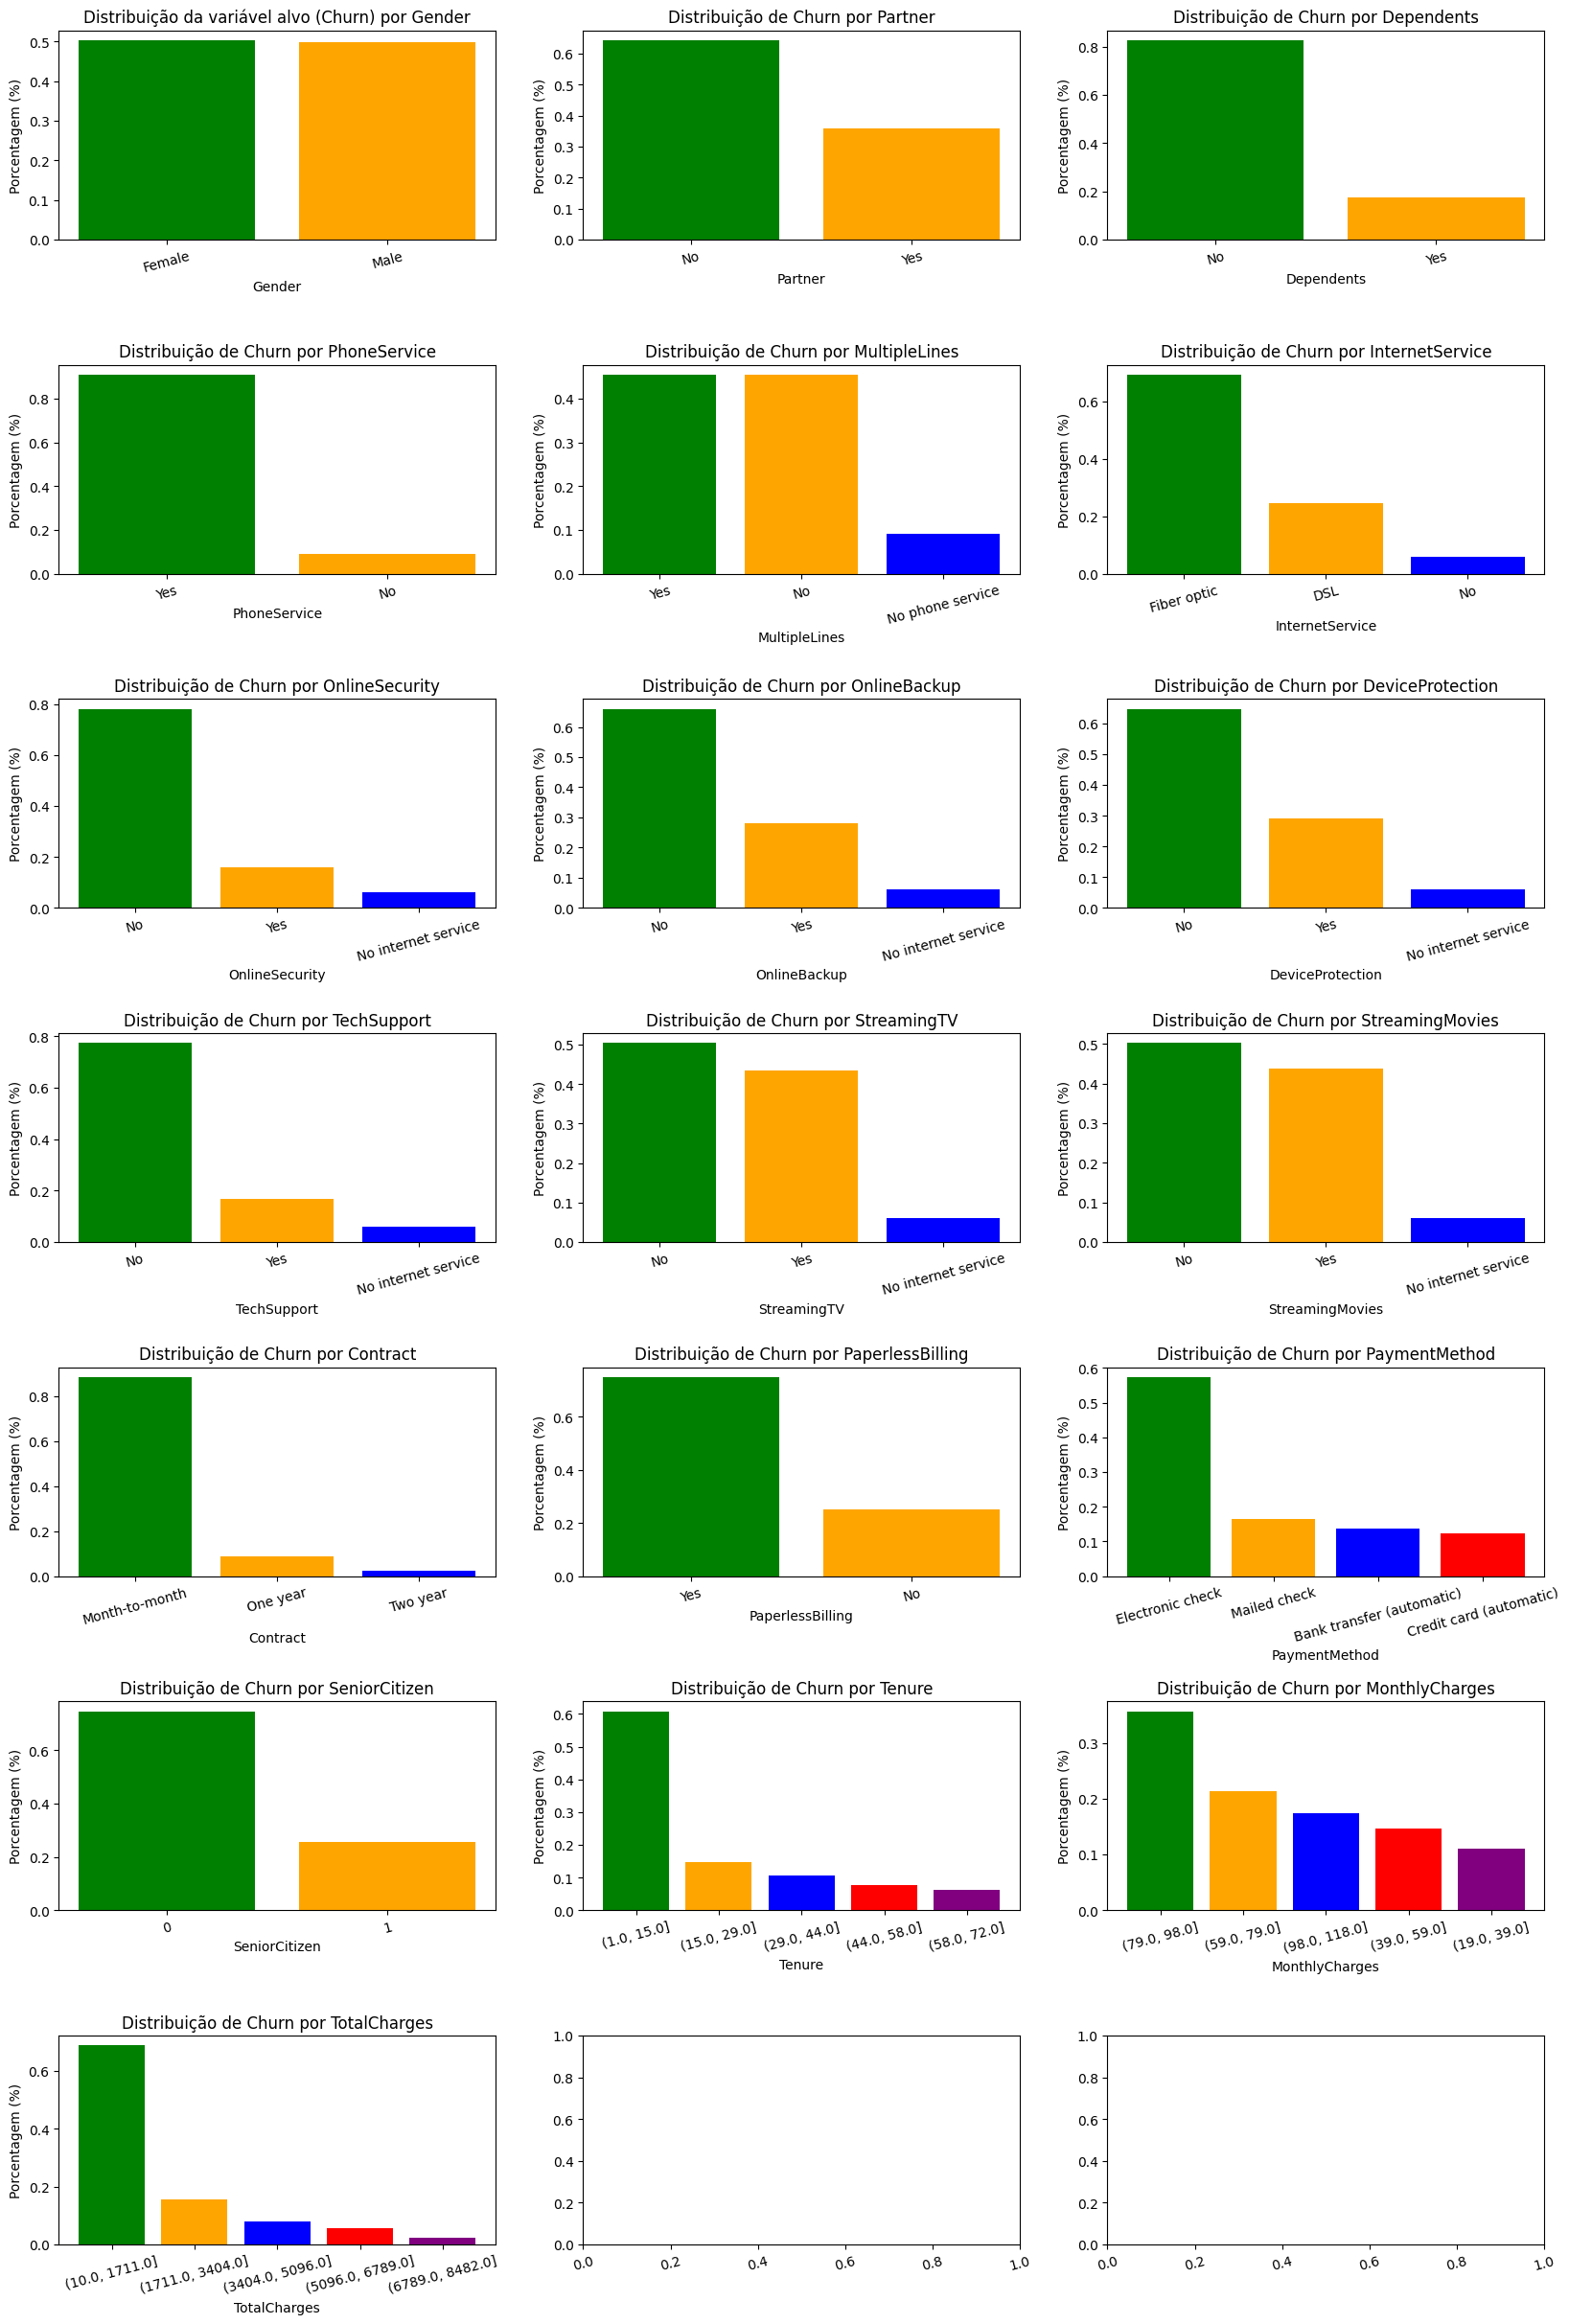

In [12]:
eda_df = df

#  Resumo estatístico das variáveis
print("Resumo estatístico para números:")
display(pd.DataFrame(eda_df.select_dtypes(include=['number']).describe()))
print("Resumo estatístico para literais:")
display(pd.DataFrame(eda_df.select_dtypes(exclude=['number']).describe()))

fig, axes = plt.subplots(7, 3, figsize=(20, 30))

data = eda_df[eda_df["Churn"] == "Yes"]["gender"].value_counts(normalize=True)
axes[0, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[0, 0].set_title("Distribuição da variável alvo (Churn) por Gender")
axes[0, 0].set_xlabel("Gender")
axes[0, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["Partner"].value_counts(normalize=True)
axes[0, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[0, 1].set_title("Distribuição de Churn por Partner")
axes[0, 1].set_xlabel("Partner")
axes[0, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["Dependents"].value_counts(normalize=True)
axes[0, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[0, 2].set_title("Distribuição de Churn por Dependents")
axes[0, 2].set_xlabel("Dependents")
axes[0, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["PhoneService"].value_counts(normalize=True)
axes[1, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[1, 0].set_title("Distribuição de Churn por PhoneService")
axes[1, 0].set_xlabel("PhoneService")
axes[1, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["MultipleLines"].value_counts(normalize=True)
axes[1, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[1, 1].set_title("Distribuição de Churn por MultipleLines")
axes[1, 1].set_xlabel("MultipleLines")
axes[1, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["InternetService"].value_counts(normalize=True)
axes[1, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[1, 2].set_title("Distribuição de Churn por InternetService")
axes[1, 2].set_xlabel("InternetService")
axes[1, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["OnlineSecurity"].value_counts(normalize=True)
axes[2, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[2, 0].set_title("Distribuição de Churn por OnlineSecurity")
axes[2, 0].set_xlabel("OnlineSecurity")
axes[2, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["OnlineBackup"].value_counts(normalize=True)
axes[2, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[2, 1].set_title("Distribuição de Churn por OnlineBackup")
axes[2, 1].set_xlabel("OnlineBackup")
axes[2, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["DeviceProtection"].value_counts(normalize=True)
axes[2, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[2, 2].set_title("Distribuição de Churn por DeviceProtection")
axes[2, 2].set_xlabel("DeviceProtection")
axes[2, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["TechSupport"].value_counts(normalize=True)
axes[3, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[3, 0].set_title("Distribuição de Churn por TechSupport")
axes[3, 0].set_xlabel("TechSupport")
axes[3, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["StreamingTV"].value_counts(normalize=True)
axes[3, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[3, 1].set_title("Distribuição de Churn por StreamingTV")
axes[3, 1].set_xlabel("StreamingTV")
axes[3, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["StreamingMovies"].value_counts(normalize=True)
axes[3, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[3, 2].set_title("Distribuição de Churn por StreamingMovies")
axes[3, 2].set_xlabel("StreamingMovies")
axes[3, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["Contract"].value_counts(normalize=True)
axes[4, 0].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[4, 0].set_title("Distribuição de Churn por Contract")
axes[4, 0].set_xlabel("Contract")
axes[4, 0].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["PaperlessBilling"].value_counts(normalize=True)
axes[4, 1].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[4, 1].set_title("Distribuição de Churn por PaperlessBilling")
axes[4, 1].set_xlabel("PaperlessBilling")
axes[4, 1].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["PaymentMethod"].value_counts(normalize=True)
axes[4, 2].bar(data.index, data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[4, 2].set_title("Distribuição de Churn por PaymentMethod")
axes[4, 2].set_xlabel("PaymentMethod")
axes[4, 2].set_ylabel("Porcentagem (%)")

data = eda_df[eda_df["Churn"] == "Yes"]["SeniorCitizen"].value_counts(normalize=True)
axes[5, 0].bar(data.index.astype(str), data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[5, 0].set_title("Distribuição de Churn por SeniorCitizen")
axes[5, 0].set_xlabel("SeniorCitizen")
axes[5, 0].set_ylabel("Porcentagem (%)")

data = pd.cut(eda_df[eda_df["Churn"] == "Yes"]["tenure"], bins=5, precision=0).value_counts(normalize=True)
axes[5, 1].bar(data.index.astype(str), data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[5, 1].set_title("Distribuição de Churn por Tenure")
axes[5, 1].set_xlabel("Tenure")
axes[5, 1].set_ylabel("Porcentagem (%)")

data = pd.cut(eda_df[eda_df["Churn"] == "Yes"]["MonthlyCharges"], bins=5, precision=0).value_counts(normalize=True)
axes[5, 2].bar(data.index.astype(str), data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[5, 2].set_title("Distribuição de Churn por MonthlyCharges")
axes[5, 2].set_xlabel("MonthlyCharges")
axes[5, 2].set_ylabel("Porcentagem (%)")

data = pd.cut(eda_df[eda_df["Churn"] == "Yes"]["TotalCharges"], bins=5, precision=0).value_counts(normalize=True)
axes[6, 0].bar(data.index.astype(str), data.values, color=["green", "orange", "blue", "red", "purple", "yellow"])
axes[6, 0].set_title("Distribuição de Churn por TotalCharges")
axes[6, 0].set_xlabel("TotalCharges")
axes[6, 0].set_ylabel("Porcentagem (%)")

# eda_df["tenure_category"] = pd.cut(eda_df["tenure"], bins=[0, 12, 24, 60, 120], labels=["0-1 ano", "1-2 anos", "2-5 anos", "5+ anos"])
# plt.figure(figsize=(8, 5))
# sns.countplot(x=eda_df["tenure_category"], hue=eda_df["Churn"])
# plt.title("Distribuição do Tempo de Cliente vs Churn")
# plt.xlabel("Tempo como Cliente")
# plt.ylabel("Contagem")
# plt.legend(title="Churn", labels=["Não", "Sim"])
# plt.show()

# eda_df["MonthlyCharges_category"] = pd.cut(eda_df["MonthlyCharges"], bins=5, labels=["Muito Baixo", "Baixo", "Médio", "Alto", "Muito Alto"])
# churn_counts = eda_df.groupby("MonthlyCharges_category", observed=True)["Churn"].value_counts(normalize=True).unstack()
# churn_counts.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="coolwarm")
# plt.title("Porcentagem Acumulativa de Churn por Faixa de Pagamento")
# plt.xlabel("Faixa de Pagamento Mensal")
# plt.ylabel("Proporção de Churn")
# plt.legend(title="Churn", labels=["Não", "Sim"])
# plt.grid(axis="y", linestyle="--", alpha=0.7)

fig.subplots_adjust(hspace=0.6)
for ax in fig.get_axes():  # Percorre todos os subgráficos
    ax.tick_params(axis="x", rotation=15)
fig.show()


# 3. Pré-processamento

### 3.1 Retirada de Duplicatas

In [13]:
df.drop_duplicates(df.columns, ignore_index=True)
print("Database's shape:", df.shape)

Database's shape: (7043, 20)


### 3.2 Retirada de Valores Faltantes

In [14]:
df.dropna(ignore_index=True)
print("Database's shape:", df.shape)

Database's shape: (7043, 20)


### 3.2 Transformação para Indicadores

In [15]:
df = pd.get_dummies(df, drop_first=True)
print("Database's shape:", df.shape)
df.head()

Database's shape: (7043, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
1,0,34,56.95,1936.30,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0,2,53.85,107.70,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,True
3,0,45,42.30,1903.50,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,0,2,70.70,141.40,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True


### 3.3. Separação dos Conjuntos de Dados

In [16]:
df_data = df.drop(columns=['Churn_Yes'])
df_target = df['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.25, stratify=df_target, random_state=50)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train, random_state=50)

# print(df_target.value_counts(normalize=True))
# print(y_train.value_counts(normalize=True))
# print(y_test.value_counts(normalize=True))

kf = SKFold(n_splits=3, shuffle=True, random_state=50)

indexesJoin = []
for i, (train_i, test_i) in enumerate(kf.split(df_data, df_target)):
    print(f'Fold {i}')
    print(f'Train:{len(train_i)} index={train_i}')
    print(f'Test:{len(test_i)} index={test_i}')
    indexesJoin.append((i, train_i, test_i))

print(indexesJoin)


Fold 0
Train:4695 index=[   1    2    3 ... 7037 7040 7042]
Test:2348 index=[   0    4    7 ... 7038 7039 7041]
Fold 1
Train:4695 index=[   0    1    4 ... 7038 7039 7041]
Test:2348 index=[   2    3    6 ... 7037 7040 7042]
Fold 2
Train:4696 index=[   0    2    3 ... 7040 7041 7042]
Test:2347 index=[   1    5   13 ... 7025 7027 7032]
[(0, array([   1,    2,    3, ..., 7037, 7040, 7042]), array([   0,    4,    7, ..., 7038, 7039, 7041])), (1, array([   0,    1,    4, ..., 7038, 7039, 7041]), array([   2,    3,    6, ..., 7037, 7040, 7042])), (2, array([   0,    2,    3, ..., 7040, 7041, 7042]), array([   1,    5,   13, ..., 7025, 7027, 7032]))]


# 4. Otimização de Hiperparâmetros com Optuna

### 4.1 Modelo MLP

In [ ]:
def objective_mlp(trial):
    # Hiperparâmetros a serem otimizados
    num_layers = trial.suggest_int("num_layers", 1, 10)
    hidden_layers = []
    for i in range(num_layers):
        hidden_layers.append(trial.suggest_int(f"hidden_layer_{i+1}", 1, 300))
    
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd", "lbfgs"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    max_iter = trial.suggest_int("max_iter", 50, 500)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True)
    
    # Criar o modelo MLP com os parâmetros sugeridos
    model = MLPClassifier(hidden_layer_sizes=tuple(hidden_layers),
                          activation=activation,
                          solver=solver,
                          alpha=alpha,
                          max_iter=max_iter,
                          learning_rate_init=learning_rate_init,
                          random_state=50)

    # Avaliar usando validação cruzada
    score = cross_val_score(model, df_data, df_target, cv=kf, scoring="accuracy").mean()
    # TODO: implementar scoring com suggest:["accuracy", "roc_auc", "precision", "recall", "f1", "ks", "matrizconfusao"]
    return score  # Maximizar a acurácia

# Criar estudo e encontrar os melhores hiperparâmetros
study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=50, show_progress_bar=True)

# Melhor conjunto de hiperparâmetros encontrados
print("Melhores hiperparâmetros:", study_mlp.best_params)

# Melhores hiperparâmetros: {'num_layers': 2, 'hidden_layer_1': 137, 'hidden_layer_2': 208, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0035572553414692305, 'max_iter': 199, 'learning_rate_init': 0.00010571778558784807}

[I 2025-03-19 19:31:58,951] A new study created in memory with name: no-name-27d1e08f-00ce-43cd-93aa-bcc09913488f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-19 19:33:37,269] Trial 0 finished with value: 0.7661501132210051 and parameters: {'num_layers': 5, 'hidden_layer_1': 278, 'hidden_layer_2': 8, 'hidden_layer_3': 284, 'hidden_layer_4': 230, 'hidden_layer_5': 251, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 1.118032109960601e-05, 'max_iter': 496, 'learning_rate_init': 0.00012916249402965583}. Best is trial 0 with value: 0.7661501132210051.
[I 2025-03-19 19:33:44,323] Trial 1 finished with value: 0.7346301185052165 and parameters: {'num_layers': 6, 'hidden_layer_1': 169, 'hidden_layer_2': 290, 'hidden_layer_3': 61, 'hidden_layer_4': 274, 'hidden_layer_5': 277, 'hidden_layer_6': 222, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 6.24545071821184e-05, 'max_iter': 413, 'learning_rate_init': 0.0006158065430147661}. Best is trial 0 with value: 0.7661501132210051.
[I 2025-03-19 19:33:45,656] Trial 2 finished with value: 0.7742450703073529 and parameters: {'num_layers': 2, 'hidden_layer_1': 82, 'hidden_layer_2': 34, 'activ

In [ ]:
# Criar modelo com os melhores hiperparâmetros
# melhores_params = study.best_params  # Pegamos os melhores parâmetros encontrados pelo Optuna
best_params_mlp = {'num_layers': 2, 'hidden_layer_1': 137, 'hidden_layer_2': 208, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0035572553414692305, 'max_iter': 199, 'learning_rate_init': 0.00010571778558784807}

modelo_final_mlp = MLPClassifier(
    hidden_layer_sizes=tuple(best_params_mlp[f"hidden_layer_{i+1}"] for i in range(best_params_mlp["num_layers"])),
    activation=best_params_mlp["activation"],
    solver=best_params_mlp["solver"],
    alpha=best_params_mlp["alpha"],
    max_iter=best_params_mlp["max_iter"],
    learning_rate_init=best_params_mlp["learning_rate_init"],
    random_state=50
)

# Treinar o modelo final com TODOS os dados (sem validação cruzada)
modelo_final_mlp.fit(df_data, df_target)

# Salvar o modelo treinado
joblib.dump(modelo_final_mlp, "modelo_final_mlp.pkl")
print("Modelo final treinado e salvo!")

Modelo final treinado e salvo!


### 4.2 Modelo Random Forest

In [21]:
def objective_rf(trial):
    # Definir os hiperparâmetros a serem otimizados para RandomForestClassifier
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    
    # Criar o modelo RandomForest com os parâmetros sugeridos
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   criterion=criterion,
                                   random_state=50)
    
    # Avaliar usando validação cruzada
    score = cross_val_score(model, df_data, df_target, cv=kf, scoring="accuracy").mean()
    # TODO: implementar scoring com suggest:["accuracy", "roc_auc", "precision", "recall", "f1", "ks", "matrizconfusao"]
    return score  # Buscamos maximizar a acurácia

# Criar estudo e encontrar os melhores hiperparâmetros
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", study_rf.best_params)

[I 2025-03-20 13:10:44,041] A new study created in memory with name: no-name-2b259ad4-9766-4d04-8e4f-5561f378c59e
Best trial: 0. Best value: 0.797103:   2%|▏         | 1/50 [00:04<03:25,  4.19s/it]

[I 2025-03-20 13:10:48,233] Trial 0 finished with value: 0.7971025512047106 and parameters: {'n_estimators': 297, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.7971025512047106.


Best trial: 1. Best value: 0.801789:   4%|▍         | 2/50 [00:05<01:51,  2.32s/it]

[I 2025-03-20 13:10:49,249] Trial 1 finished with value: 0.8017886596079861 and parameters: {'n_estimators': 198, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 1 with value: 0.8017886596079861.


Best trial: 1. Best value: 0.801789:   6%|▌         | 3/50 [00:08<02:14,  2.87s/it]

[I 2025-03-20 13:10:52,771] Trial 2 finished with value: 0.7962510043993963 and parameters: {'n_estimators': 152, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': None, 'criterion': 'gini'}. Best is trial 1 with value: 0.8017886596079861.


Best trial: 1. Best value: 0.801789:   8%|▊         | 4/50 [00:13<02:42,  3.54s/it]

[I 2025-03-20 13:10:57,334] Trial 3 finished with value: 0.7983800528759878 and parameters: {'n_estimators': 282, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': None, 'criterion': 'gini'}. Best is trial 1 with value: 0.8017886596079861.


Best trial: 1. Best value: 0.801789:  10%|█         | 5/50 [00:13<01:51,  2.47s/it]

[I 2025-03-20 13:10:57,913] Trial 4 finished with value: 0.7885848451041321 and parameters: {'n_estimators': 152, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 1 with value: 0.8017886596079861.


Best trial: 1. Best value: 0.801789:  12%|█▏        | 6/50 [00:14<01:28,  2.00s/it]

[I 2025-03-20 13:10:59,004] Trial 5 finished with value: 0.7990910865950153 and parameters: {'n_estimators': 198, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.8017886596079861.


Best trial: 6. Best value: 0.802499:  14%|█▍        | 7/50 [00:17<01:35,  2.22s/it]

[I 2025-03-20 13:11:01,685] Trial 6 finished with value: 0.8024986650349485 and parameters: {'n_estimators': 354, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 6 with value: 0.8024986650349485.


Best trial: 6. Best value: 0.802499:  16%|█▌        | 8/50 [00:20<01:40,  2.39s/it]

[I 2025-03-20 13:11:04,445] Trial 7 finished with value: 0.7962512463504705 and parameters: {'n_estimators': 352, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 6 with value: 0.8024986650349485.


Best trial: 6. Best value: 0.802499:  18%|█▊        | 9/50 [00:21<01:20,  1.97s/it]

[I 2025-03-20 13:11:05,487] Trial 8 finished with value: 0.8017884176569119 and parameters: {'n_estimators': 185, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 6 with value: 0.8024986650349485.


Best trial: 6. Best value: 0.802499:  20%|██        | 10/50 [00:22<01:04,  1.62s/it]

[I 2025-03-20 13:11:06,320] Trial 9 finished with value: 0.7944056435571937 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 6 with value: 0.8024986650349485.


Best trial: 6. Best value: 0.802499:  22%|██▏       | 11/50 [00:25<01:23,  2.15s/it]

[I 2025-03-20 13:11:09,666] Trial 10 finished with value: 0.802214070084032 and parameters: {'n_estimators': 456, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 6 with value: 0.8024986650349485.


Best trial: 6. Best value: 0.802499:  24%|██▍       | 12/50 [00:29<01:38,  2.60s/it]

[I 2025-03-20 13:11:13,299] Trial 11 finished with value: 0.8016460294498008 and parameters: {'n_estimators': 497, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 6 with value: 0.8024986650349485.


Best trial: 6. Best value: 0.802499:  26%|██▌       | 13/50 [00:32<01:44,  2.82s/it]

[I 2025-03-20 13:11:16,637] Trial 12 finished with value: 0.8017881757058377 and parameters: {'n_estimators': 437, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 6 with value: 0.8024986650349485.


Best trial: 6. Best value: 0.802499:  28%|██▊       | 14/50 [00:35<01:42,  2.86s/it]

[I 2025-03-20 13:11:19,579] Trial 13 finished with value: 0.8009363264616809 and parameters: {'n_estimators': 393, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 6 with value: 0.8024986650349485.


Best trial: 14. Best value: 0.803634:  30%|███       | 15/50 [00:39<01:47,  3.07s/it]

[I 2025-03-20 13:11:23,135] Trial 14 finished with value: 0.8036338389868831 and parameters: {'n_estimators': 497, 'max_depth': 25, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 14 with value: 0.8036338389868831.


Best trial: 14. Best value: 0.803634:  32%|███▏      | 16/50 [00:41<01:37,  2.87s/it]

[I 2025-03-20 13:11:25,552] Trial 15 finished with value: 0.802356216340069 and parameters: {'n_estimators': 349, 'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 14 with value: 0.8036338389868831.


Best trial: 14. Best value: 0.803634:  34%|███▍      | 17/50 [00:42<01:12,  2.21s/it]

[I 2025-03-20 13:11:26,217] Trial 16 finished with value: 0.8022141910595691 and parameters: {'n_estimators': 96, 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 14 with value: 0.8036338389868831.


Best trial: 17. Best value: 0.804202:  36%|███▌      | 18/50 [00:45<01:17,  2.42s/it]

[I 2025-03-20 13:11:29,123] Trial 17 finished with value: 0.8042018796211142 and parameters: {'n_estimators': 408, 'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 17 with value: 0.8042018796211142.


Best trial: 18. Best value: 0.804486:  38%|███▊      | 19/50 [00:48<01:25,  2.76s/it]

[I 2025-03-20 13:11:32,690] Trial 18 finished with value: 0.8044858696943455 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 18. Best value: 0.804486:  40%|████      | 20/50 [00:51<01:24,  2.81s/it]

[I 2025-03-20 13:11:35,618] Trial 19 finished with value: 0.803066161279263 and parameters: {'n_estimators': 425, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 18. Best value: 0.804486:  42%|████▏     | 21/50 [01:01<02:24,  4.99s/it]

[I 2025-03-20 13:11:45,692] Trial 20 finished with value: 0.7949733212648137 and parameters: {'n_estimators': 405, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': None, 'criterion': 'entropy'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 18. Best value: 0.804486:  44%|████▍     | 22/50 [01:05<02:06,  4.53s/it]

[I 2025-03-20 13:11:49,140] Trial 21 finished with value: 0.8039180105234202 and parameters: {'n_estimators': 495, 'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 18. Best value: 0.804486:  46%|████▌     | 23/50 [01:08<01:52,  4.18s/it]

[I 2025-03-20 13:11:52,503] Trial 22 finished with value: 0.8020721657790691 and parameters: {'n_estimators': 465, 'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 18. Best value: 0.804486:  48%|████▊     | 24/50 [01:11<01:41,  3.92s/it]

[I 2025-03-20 13:11:55,828] Trial 23 finished with value: 0.8040602172672257 and parameters: {'n_estimators': 481, 'max_depth': 27, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 18. Best value: 0.804486:  50%|█████     | 25/50 [01:14<01:27,  3.52s/it]

[I 2025-03-20 13:11:58,404] Trial 24 finished with value: 0.8036338994746516 and parameters: {'n_estimators': 391, 'max_depth': 27, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 18. Best value: 0.804486:  52%|█████▏    | 26/50 [01:17<01:22,  3.42s/it]

[I 2025-03-20 13:12:01,585] Trial 25 finished with value: 0.8024983021083374 and parameters: {'n_estimators': 456, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 18. Best value: 0.804486:  54%|█████▍    | 27/50 [01:20<01:13,  3.21s/it]

[I 2025-03-20 13:12:04,310] Trial 26 finished with value: 0.8036341414257256 and parameters: {'n_estimators': 424, 'max_depth': 27, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 18 with value: 0.8044858696943455.


Best trial: 27. Best value: 0.805338:  56%|█████▌    | 28/50 [01:22<01:03,  2.90s/it]

[I 2025-03-20 13:12:06,503] Trial 27 finished with value: 0.8053380213773451 and parameters: {'n_estimators': 305, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  58%|█████▊    | 29/50 [01:29<01:24,  4.04s/it]

[I 2025-03-20 13:12:13,199] Trial 28 finished with value: 0.7939795677156939 and parameters: {'n_estimators': 244, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': None, 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  60%|██████    | 30/50 [01:30<01:02,  3.15s/it]

[I 2025-03-20 13:12:14,256] Trial 29 finished with value: 0.7474094903373208 and parameters: {'n_estimators': 317, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  62%|██████▏   | 31/50 [01:37<01:20,  4.25s/it]

[I 2025-03-20 13:12:21,092] Trial 30 finished with value: 0.7918500958247229 and parameters: {'n_estimators': 243, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  64%|██████▍   | 32/50 [01:39<01:08,  3.80s/it]

[I 2025-03-20 13:12:23,824] Trial 31 finished with value: 0.8027819292549577 and parameters: {'n_estimators': 375, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  66%|██████▌   | 33/50 [01:42<00:56,  3.35s/it]

[I 2025-03-20 13:12:26,135] Trial 32 finished with value: 0.8037760457306886 and parameters: {'n_estimators': 310, 'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  68%|██████▊   | 34/50 [01:45<00:54,  3.38s/it]

[I 2025-03-20 13:12:29,597] Trial 33 finished with value: 0.8030661007914945 and parameters: {'n_estimators': 468, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  70%|███████   | 35/50 [01:48<00:49,  3.32s/it]

[I 2025-03-20 13:12:32,766] Trial 34 finished with value: 0.8036341414257256 and parameters: {'n_estimators': 474, 'max_depth': 26, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  72%|███████▏  | 36/50 [01:51<00:43,  3.11s/it]

[I 2025-03-20 13:12:35,374] Trial 35 finished with value: 0.8016464528641806 and parameters: {'n_estimators': 422, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  74%|███████▍  | 37/50 [01:58<00:54,  4.20s/it]

[I 2025-03-20 13:12:42,131] Trial 36 finished with value: 0.7948315984231565 and parameters: {'n_estimators': 271, 'max_depth': 28, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'gini'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  76%|███████▌  | 38/50 [02:00<00:43,  3.65s/it]

[I 2025-03-20 13:12:44,505] Trial 37 finished with value: 0.80377598524292 and parameters: {'n_estimators': 334, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  78%|███████▊  | 39/50 [02:03<00:37,  3.38s/it]

[I 2025-03-20 13:12:47,264] Trial 38 finished with value: 0.8040597938528458 and parameters: {'n_estimators': 374, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  80%|████████  | 40/50 [02:03<00:25,  2.53s/it]

[I 2025-03-20 13:12:47,790] Trial 39 finished with value: 0.8026407508032172 and parameters: {'n_estimators': 80, 'max_depth': 28, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  82%|████████▏ | 41/50 [02:05<00:21,  2.34s/it]

[I 2025-03-20 13:12:49,702] Trial 40 finished with value: 0.800652396876218 and parameters: {'n_estimators': 283, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  84%|████████▍ | 42/50 [02:08<00:19,  2.49s/it]

[I 2025-03-20 13:12:52,533] Trial 41 finished with value: 0.8040597938528458 and parameters: {'n_estimators': 383, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  86%|████████▌ | 43/50 [02:11<00:17,  2.54s/it]

[I 2025-03-20 13:12:55,194] Trial 42 finished with value: 0.803350211840263 and parameters: {'n_estimators': 371, 'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  88%|████████▊ | 44/50 [02:14<00:16,  2.78s/it]

[I 2025-03-20 13:12:58,537] Trial 43 finished with value: 0.8034921161452259 and parameters: {'n_estimators': 446, 'max_depth': 23, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  90%|█████████ | 45/50 [02:18<00:15,  3.03s/it]

[I 2025-03-20 13:13:02,149] Trial 44 finished with value: 0.8033499698891888 and parameters: {'n_estimators': 480, 'max_depth': 26, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  92%|█████████▏| 46/50 [02:20<00:11,  2.96s/it]

[I 2025-03-20 13:13:04,940] Trial 45 finished with value: 0.8017882966813749 and parameters: {'n_estimators': 408, 'max_depth': 29, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  94%|█████████▍| 47/50 [02:23<00:08,  2.80s/it]

[I 2025-03-20 13:13:07,364] Trial 46 finished with value: 0.8036340204501887 and parameters: {'n_estimators': 338, 'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  96%|█████████▌| 48/50 [02:25<00:05,  2.70s/it]

[I 2025-03-20 13:13:09,819] Trial 47 finished with value: 0.8027819897427261 and parameters: {'n_estimators': 366, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338:  98%|█████████▊| 49/50 [02:37<00:05,  5.44s/it]

[I 2025-03-20 13:13:21,675] Trial 48 finished with value: 0.7907138330929548 and parameters: {'n_estimators': 434, 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.


Best trial: 27. Best value: 0.805338: 100%|██████████| 50/50 [02:39<00:00,  3.20s/it]

[I 2025-03-20 13:13:23,914] Trial 49 finished with value: 0.8032082470475315 and parameters: {'n_estimators': 319, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 27 with value: 0.8053380213773451.
Melhores hiperparâmetros: {'n_estimators': 305, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}


In [22]:
# Criar modelo com os melhores hiperparâmetros
# melhores_params = study.best_params  # Pegamos os melhores parâmetros encontrados pelo Optuna
best_params_rf = study_rf.best_params

modelo_final_rf = RandomForestClassifier(n_estimators=best_params_rf["n_estimators"],
                                      max_depth=best_params_rf["max_depth"],
                                      min_samples_split=best_params_rf["min_samples_split"],
                                      min_samples_leaf=best_params_rf["min_samples_leaf"],
                                      max_features=best_params_rf["max_features"],
                                      criterion=best_params_rf["criterion"],
                                      random_state=50)

# Se desejar, você pode dividir em treino/teste; aqui usamos TODOS os dados para o treinamento final
modelo_final_rf.fit(df_data, df_target)

# Salvar o modelo treinado
joblib.dump(modelo_final_rf, "modelo_final_rf.pkl")
print("Modelo final treinado e salvo!")

Modelo final treinado e salvo!


### 4.3 Modelo Gradient Boosting

In [26]:
def objective_gb(trial):
    # Hiperparâmetros a serem otimizados para o GradientBoostingClassifier
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    subsample = trial.suggest_float("subsample", 0.3, 1.0)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    # Criar o modelo com os hiperparâmetros sugeridos
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        random_state=50
    )
    
    # Avaliar o modelo usando validação cruzada com a métrica de acurácia
    score = cross_val_score(model, df_data, df_target, cv=kf, scoring="accuracy").mean()
    return score  # Queremos maximizar a acurácia

# Criar o estudo do Optuna e otimizar
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(objective_gb, n_trials=50, show_progress_bar=True)

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", study_gb.best_params)

[I 2025-03-20 13:23:28,869] A new study created in memory with name: no-name-6834928a-13f2-4548-9ba6-e7eac89055f2
Best trial: 0. Best value: 0.777082:   2%|▏         | 1/50 [00:02<02:17,  2.80s/it]

[I 2025-03-20 13:23:31,667] Trial 0 finished with value: 0.7770821886023139 and parameters: {'n_estimators': 332, 'learning_rate': 0.17035422840574124, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.8708306422688086, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7770821886023139.


Best trial: 0. Best value: 0.777082:   4%|▍         | 2/50 [00:04<01:34,  1.96s/it]

[I 2025-03-20 13:23:33,046] Trial 1 finished with value: 0.7346301185052165 and parameters: {'n_estimators': 207, 'learning_rate': 0.0014344938510132727, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 9, 'subsample': 0.915144405974927, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7770821886023139.


Best trial: 2. Best value: 0.804628:   6%|▌         | 3/50 [00:04<01:01,  1.31s/it]

[I 2025-03-20 13:23:33,579] Trial 2 finished with value: 0.8046281974136882 and parameters: {'n_estimators': 136, 'learning_rate': 0.12568612976380436, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 1, 'subsample': 0.6087517557736888, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:   8%|▊         | 4/50 [00:08<01:40,  2.18s/it]

[I 2025-03-20 13:23:37,105] Trial 3 finished with value: 0.8022146749617173 and parameters: {'n_estimators': 346, 'learning_rate': 0.006009904128244403, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 8, 'subsample': 0.9981168572749539, 'max_features': 'log2'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  10%|█         | 5/50 [00:14<02:48,  3.75s/it]

[I 2025-03-20 13:23:43,639] Trial 4 finished with value: 0.7346301185052165 and parameters: {'n_estimators': 171, 'learning_rate': 0.0013852640833816874, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7385815090060381, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  12%|█▏        | 6/50 [00:19<03:01,  4.14s/it]

[I 2025-03-20 13:23:48,516] Trial 5 finished with value: 0.7951151045942395 and parameters: {'n_estimators': 402, 'learning_rate': 0.003109919635701285, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 8, 'subsample': 0.3284989273514726, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  14%|█▍        | 7/50 [00:22<02:36,  3.64s/it]

[I 2025-03-20 13:23:51,136] Trial 6 finished with value: 0.7827627764079313 and parameters: {'n_estimators': 202, 'learning_rate': 0.004376856427377686, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.4036982509914478, 'max_features': 'log2'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  16%|█▌        | 8/50 [00:25<02:32,  3.63s/it]

[I 2025-03-20 13:23:54,756] Trial 7 finished with value: 0.8026405693399115 and parameters: {'n_estimators': 306, 'learning_rate': 0.024681113733554996, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 6, 'subsample': 0.5986929859862322, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  18%|█▊        | 9/50 [00:26<01:54,  2.79s/it]

[I 2025-03-20 13:23:55,676] Trial 8 finished with value: 0.7346301185052165 and parameters: {'n_estimators': 401, 'learning_rate': 0.0021376829323919927, 'max_depth': 1, 'min_samples_split': 17, 'min_samples_leaf': 10, 'subsample': 0.5036742967423103, 'max_features': 'log2'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  22%|██▏       | 11/50 [00:28<01:06,  1.70s/it]

[I 2025-03-20 13:23:57,106] Trial 9 finished with value: 0.7346301185052165 and parameters: {'n_estimators': 338, 'learning_rate': 0.0017409513806396688, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 10, 'subsample': 0.4138013931231439, 'max_features': 'log2'}. Best is trial 2 with value: 0.8046281974136882.
[I 2025-03-20 13:23:57,288] Trial 10 finished with value: 0.8002266839613293 and parameters: {'n_estimators': 63, 'learning_rate': 0.2375775915098841, 'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.674944924757559, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  24%|██▍       | 12/50 [00:29<00:52,  1.39s/it]

[I 2025-03-20 13:23:57,962] Trial 11 finished with value: 0.8013620998643379 and parameters: {'n_estimators': 58, 'learning_rate': 0.04769148086667553, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 5, 'subsample': 0.5505882442840113, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  26%|██▌       | 13/50 [00:31<01:03,  1.71s/it]

[I 2025-03-20 13:24:00,426] Trial 12 finished with value: 0.8036341414257256 and parameters: {'n_estimators': 266, 'learning_rate': 0.029617378660056252, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 5, 'subsample': 0.5949720438434483, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  28%|██▊       | 14/50 [00:33<01:00,  1.69s/it]

[I 2025-03-20 13:24:02,074] Trial 13 finished with value: 0.8022144330106432 and parameters: {'n_estimators': 499, 'learning_rate': 0.06635391899110248, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 3, 'subsample': 0.7353543387565117, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  30%|███       | 15/50 [00:34<00:57,  1.63s/it]

[I 2025-03-20 13:24:03,565] Trial 14 finished with value: 0.7912822366537973 and parameters: {'n_estimators': 143, 'learning_rate': 0.011631299419160024, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.6663551287148433, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  32%|███▏      | 16/50 [00:37<01:06,  1.96s/it]

[I 2025-03-20 13:24:06,286] Trial 15 finished with value: 0.7793555004068408 and parameters: {'n_estimators': 249, 'learning_rate': 0.0942158011267658, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.48003203413133233, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  34%|███▍      | 17/50 [00:38<00:54,  1.65s/it]

[I 2025-03-20 13:24:07,231] Trial 16 finished with value: 0.7934114665936942 and parameters: {'n_estimators': 117, 'learning_rate': 0.026906583983230717, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.7474845373922204, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  36%|███▌      | 18/50 [00:39<00:46,  1.46s/it]

[I 2025-03-20 13:24:08,228] Trial 17 finished with value: 0.7968192869847016 and parameters: {'n_estimators': 261, 'learning_rate': 0.1163005005741432, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 7, 'subsample': 0.5928278324822431, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  38%|███▊      | 19/50 [00:40<00:43,  1.41s/it]

[I 2025-03-20 13:24:09,514] Trial 18 finished with value: 0.7878741138239472 and parameters: {'n_estimators': 104, 'learning_rate': 0.015727607481217667, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.8535044827688081, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  40%|████      | 20/50 [00:41<00:41,  1.38s/it]

[I 2025-03-20 13:24:10,822] Trial 19 finished with value: 0.7986647083146728 and parameters: {'n_estimators': 233, 'learning_rate': 0.049967480041326694, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.47268252302470515, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  42%|████▏     | 21/50 [00:43<00:38,  1.33s/it]

[I 2025-03-20 13:24:12,048] Trial 20 finished with value: 0.7955414223868135 and parameters: {'n_estimators': 174, 'learning_rate': 0.29193138013562064, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 2, 'subsample': 0.6004618220874761, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  44%|████▍     | 22/50 [00:46<00:56,  2.01s/it]

[I 2025-03-20 13:24:15,624] Trial 21 finished with value: 0.8020724077301432 and parameters: {'n_estimators': 297, 'learning_rate': 0.022372615894472772, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 6, 'subsample': 0.5912051493272535, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  46%|████▌     | 23/50 [00:51<01:19,  2.94s/it]

[I 2025-03-20 13:24:20,751] Trial 22 finished with value: 0.8037761062184572 and parameters: {'n_estimators': 397, 'learning_rate': 0.009046880517023032, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 7, 'subsample': 0.6658296484780878, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  48%|████▊     | 24/50 [00:57<01:37,  3.75s/it]

[I 2025-03-20 13:24:26,393] Trial 23 finished with value: 0.8037764691450683 and parameters: {'n_estimators': 496, 'learning_rate': 0.009369276582431568, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 7, 'subsample': 0.7913358235758151, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 2. Best value: 0.804628:  50%|█████     | 25/50 [01:06<02:09,  5.20s/it]

[I 2025-03-20 13:24:34,960] Trial 24 finished with value: 0.8040599148283829 and parameters: {'n_estimators': 473, 'learning_rate': 0.011369379976942168, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 7, 'subsample': 0.7832032769974686, 'max_features': None}. Best is trial 2 with value: 0.8046281974136882.


Best trial: 25. Best value: 0.805196:  52%|█████▏    | 26/50 [01:10<02:02,  5.08s/it]

[I 2025-03-20 13:24:39,781] Trial 25 finished with value: 0.8051960565846139 and parameters: {'n_estimators': 481, 'learning_rate': 0.007082918136090272, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 8, 'subsample': 0.8015857617301785, 'max_features': 'sqrt'}. Best is trial 25 with value: 0.8051960565846139.


Best trial: 25. Best value: 0.805196:  54%|█████▍    | 27/50 [01:16<02:03,  5.37s/it]

[I 2025-03-20 13:24:45,823] Trial 26 finished with value: 0.8003693746072832 and parameters: {'n_estimators': 454, 'learning_rate': 0.003840570318441234, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 8, 'subsample': 0.8181459905260285, 'max_features': 'sqrt'}. Best is trial 25 with value: 0.8051960565846139.


Best trial: 25. Best value: 0.805196:  56%|█████▌    | 28/50 [01:21<01:55,  5.24s/it]

[I 2025-03-20 13:24:50,762] Trial 27 finished with value: 0.8047702831819565 and parameters: {'n_estimators': 450, 'learning_rate': 0.006106552080767701, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 8, 'subsample': 0.9202933561698604, 'max_features': 'sqrt'}. Best is trial 25 with value: 0.8051960565846139.


Best trial: 28. Best value: 0.80619:  58%|█████▊    | 29/50 [01:27<01:53,  5.42s/it] 

[I 2025-03-20 13:24:56,588] Trial 28 finished with value: 0.8061901125725762 and parameters: {'n_estimators': 429, 'learning_rate': 0.005695585324779956, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 9, 'subsample': 0.9214799466730439, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  60%|██████    | 30/50 [01:33<01:50,  5.54s/it]

[I 2025-03-20 13:25:02,423] Trial 29 finished with value: 0.8050542127674195 and parameters: {'n_estimators': 439, 'learning_rate': 0.006451655793247282, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.9353152703877914, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  62%|██████▏   | 31/50 [01:41<01:56,  6.11s/it]

[I 2025-03-20 13:25:09,872] Trial 30 finished with value: 0.7894356055684556 and parameters: {'n_estimators': 425, 'learning_rate': 0.0025905645584389184, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9, 'subsample': 0.9914154388273804, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  64%|██████▍   | 32/50 [01:45<01:42,  5.69s/it]

[I 2025-03-20 13:25:14,561] Trial 31 finished with value: 0.8060479058287707 and parameters: {'n_estimators': 442, 'learning_rate': 0.006109247412939357, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.9099088544027663, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  66%|██████▌   | 33/50 [01:49<01:27,  5.16s/it]

[I 2025-03-20 13:25:18,478] Trial 32 finished with value: 0.8022147959372544 and parameters: {'n_estimators': 361, 'learning_rate': 0.0052175731884937905, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9, 'subsample': 0.9323188530667652, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  68%|██████▊   | 34/50 [01:55<01:26,  5.40s/it]

[I 2025-03-20 13:25:24,451] Trial 33 finished with value: 0.7346301185052165 and parameters: {'n_estimators': 444, 'learning_rate': 0.0010495140437413158, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8773779857256279, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  70%|███████   | 35/50 [02:01<01:23,  5.57s/it]

[I 2025-03-20 13:25:30,414] Trial 34 finished with value: 0.803350211840263 and parameters: {'n_estimators': 377, 'learning_rate': 0.006885315989405633, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.9515477674301731, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  72%|███████▏  | 36/50 [02:05<01:12,  5.18s/it]

[I 2025-03-20 13:25:34,682] Trial 35 finished with value: 0.7998007895831352 and parameters: {'n_estimators': 425, 'learning_rate': 0.014833594600487996, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8712962321525204, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  74%|███████▍  | 37/50 [02:09<01:03,  4.87s/it]

[I 2025-03-20 13:25:38,823] Trial 36 finished with value: 0.7944058250204993 and parameters: {'n_estimators': 474, 'learning_rate': 0.003135489571331933, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 10, 'subsample': 0.9726428404165955, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  76%|███████▌  | 38/50 [02:16<01:04,  5.39s/it]

[I 2025-03-20 13:25:45,430] Trial 37 finished with value: 0.8000842352664498 and parameters: {'n_estimators': 428, 'learning_rate': 0.007564246774813022, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 9, 'subsample': 0.8885595220012584, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  78%|███████▊  | 39/50 [02:19<00:51,  4.71s/it]

[I 2025-03-20 13:25:48,550] Trial 38 finished with value: 0.8013628862053288 and parameters: {'n_estimators': 373, 'learning_rate': 0.005091636357881767, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.8436024299882973, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  80%|████████  | 40/50 [02:26<00:52,  5.23s/it]

[I 2025-03-20 13:25:55,012] Trial 39 finished with value: 0.802214856425023 and parameters: {'n_estimators': 477, 'learning_rate': 0.004097755895600759, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 9, 'subsample': 0.9026677846399417, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  82%|████████▏ | 41/50 [02:29<00:41,  4.62s/it]

[I 2025-03-20 13:25:58,188] Trial 40 finished with value: 0.7773675094064529 and parameters: {'n_estimators': 307, 'learning_rate': 0.0029183912559652735, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 10, 'subsample': 0.9491076521687147, 'max_features': 'log2'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  84%|████████▍ | 42/50 [02:34<00:37,  4.68s/it]

[I 2025-03-20 13:26:03,021] Trial 41 finished with value: 0.8042021820599569 and parameters: {'n_estimators': 448, 'learning_rate': 0.0069874510726434655, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 8, 'subsample': 0.9041941964741061, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  86%|████████▌ | 43/50 [02:37<00:30,  4.35s/it]

[I 2025-03-20 13:26:06,585] Trial 42 finished with value: 0.804628741803605 and parameters: {'n_estimators': 407, 'learning_rate': 0.006120926469275312, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 8, 'subsample': 0.9301716172945687, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  88%|████████▊ | 44/50 [02:43<00:29,  4.84s/it]

[I 2025-03-20 13:26:12,590] Trial 43 finished with value: 0.8010781702788753 and parameters: {'n_estimators': 456, 'learning_rate': 0.011766306039157626, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 8, 'subsample': 0.9959792520388832, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  90%|█████████ | 45/50 [02:51<00:28,  5.73s/it]

[I 2025-03-20 13:26:20,386] Trial 44 finished with value: 0.7804908558220808 and parameters: {'n_estimators': 480, 'learning_rate': 0.0017621138833627899, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 9, 'subsample': 0.826430495182785, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  92%|█████████▏| 46/50 [02:58<00:23,  5.99s/it]

[I 2025-03-20 13:26:26,967] Trial 45 finished with value: 0.7972453023384328 and parameters: {'n_estimators': 390, 'learning_rate': 0.0037399068781385214, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 10, 'subsample': 0.9149394928672796, 'max_features': 'log2'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  94%|█████████▍| 47/50 [03:02<00:16,  5.40s/it]

[I 2025-03-20 13:26:30,997] Trial 46 finished with value: 0.8033500908647259 and parameters: {'n_estimators': 414, 'learning_rate': 0.00879748099758605, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 7, 'subsample': 0.7111165306137024, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  96%|█████████▌| 48/50 [03:05<00:09,  4.90s/it]

[I 2025-03-20 13:26:34,738] Trial 47 finished with value: 0.8003689511929034 and parameters: {'n_estimators': 350, 'learning_rate': 0.005058108889883341, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 9, 'subsample': 0.8001451238081576, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619:  98%|█████████▊| 49/50 [03:11<00:05,  5.02s/it]

[I 2025-03-20 13:26:40,037] Trial 48 finished with value: 0.7941213510451197 and parameters: {'n_estimators': 437, 'learning_rate': 0.019936229715370755, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 8, 'subsample': 0.7599255795348283, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8061901125725762.


Best trial: 28. Best value: 0.80619: 100%|██████████| 50/50 [03:14<00:00,  3.90s/it]

[I 2025-03-20 13:26:43,839] Trial 49 finished with value: 0.7746702993200932 and parameters: {'n_estimators': 459, 'learning_rate': 0.001974485047565134, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 10, 'subsample': 0.9635808716070401, 'max_features': 'log2'}. Best is trial 28 with value: 0.8061901125725762.
Melhores hiperparâmetros: {'n_estimators': 429, 'learning_rate': 0.005695585324779956, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 9, 'subsample': 0.9214799466730439, 'max_features': 'sqrt'}


In [29]:
# Treinar o modelo final usando todos os dados com os melhores hiperparâmetros
best_params_gb = study_gb.best_params
modelo_final_gb = GradientBoostingClassifier(
    n_estimators=best_params_gb["n_estimators"],
    learning_rate=best_params_gb["learning_rate"],
    max_depth=best_params_gb["max_depth"],
    min_samples_split=best_params_gb["min_samples_split"],
    min_samples_leaf=best_params_gb["min_samples_leaf"],
    subsample=best_params_gb["subsample"],
    max_features=best_params_gb["max_features"],
    random_state=50
)

modelo_final_gb.fit(df_data, df_target)

# Salvar o modelo treinado
joblib.dump(modelo_final_gb, "modelo_final_gb.pkl")
print("Modelo final treinado e salvo!")

Modelo final treinado e salvo!


### 4.4 Modelo KANs

In [20]:
def objective_kan(trial):
    # Hiperparâmetros a serem otimizados para o KAN
    num_layers = trial.suggest_int("num_layers", 1, 10)
    hidden_layers = []
    for i in range(num_layers):
        hidden_layers.append(trial.suggest_int(f"hidden_layer_{i+1}", 1, 300))
        
    regularize_activation = trial.suggest_float("regularize_activation", 0.1, 1.0)
    regularize_entropy = trial.suggest_float("regularize_entropy", 0.1, 1.0)
    regularize_ridge = trial.suggest_float("regularize_ridge", 0.1, 1.0)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    
    # Criar o modelo com os hiperparâmetros sugeridos
    model = KANClassifier(
        regularize_activation=regularize_activation,
        regularize_entropy=regularize_entropy,
        regularize_ridge=regularize_ridge,
        device='cuda',
        learning_rate=learning_rate,
        random_state=50
    )
    
    # Avaliar o modelo usando validação cruzada com a métrica de acurácia
    score = cross_val_score(model, df_data, df_target, cv=kf, scoring="accuracy").mean()
    return score  # Queremos maximizar a acurácia

# Criar o estudo do Optuna e otimizar
study_kan = optuna.create_study(direction="maximize")
study_kan.optimize(objective_kan, n_trials=50, show_progress_bar=True)

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", study_kan.best_params)

[I 2025-03-21 12:56:35,668] A new study created in memory with name: no-name-8103a138-eeec-4672-8c88-cf3370a205f9
  0%|          | 0/50 [00:00<?, ?it/s]

[W 2025-03-21 12:56:35,676] Trial 0 failed with parameters: {'num_layers': 4, 'hidden_layer_1': 55, 'hidden_layer_2': 217, 'hidden_layer_3': 265, 'hidden_layer_4': 145, 'regularize_activation': 0.41402764135495407, 'regularize_entropy': 0.1459033588633497, 'regularize_ridge': 0.8898958682751483, 'learning_rate': 0.1638172745039103} because of the following error: AttributeError("'KANClassifier' object has no attribute 'hidden_layer_size'").
Traceback (most recent call last):
  File "/home/ph/googleDrive/STUDYING/UFPE/IF702 RN/Projeto-IF702/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_7004/1769283947.py", line 24, in objective_kan
    score = cross_val_score(model, df_data, df_target, cv=kf, scoring="accuracy").mean()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ph/googleDrive/STUDYING/UFPE/IF702 RN/Projet

AttributeError: 'KANClassifier' object has no attribute 'hidden_layer_size'

In [ ]:
# Treinar o modelo final usando todos os dados com os melhores hiperparâmetros
best_params_gb = study_gb.best_params
modelo_final_gb = GradientBoostingClassifier(
    n_estimators=best_params_gb["n_estimators"],
    learning_rate=best_params_gb["learning_rate"],
    max_depth=best_params_gb["max_depth"],
    min_samples_split=best_params_gb["min_samples_split"],
    min_samples_leaf=best_params_gb["min_samples_leaf"],
    subsample=best_params_gb["subsample"],
    max_features=best_params_gb["max_features"],
    random_state=50
)

modelo_final_gb.fit(df_data, df_target)

# Salvar o modelo treinado
joblib.dump(modelo_final_gb, "modelo_final_gb.pkl")
print("Modelo final treinado e salvo!")

Modelo final treinado e salvo!


# 5. Previsões

In [ ]:
# TODO: O QUE É ISSO ?


In [ ]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [33]:
df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']] = df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']].replace({'Yes': 1, 'No': 0})
df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].replace({'Yes': 1, 'No': 0, 'No internet service': 0})
df['gender'] = df['gender'].replace({'Female':1, 'Male':0})
#df['InternetService'] = df['InternetService'].replace({'Fiber optic': 2, 'DSL': 1 , 'No': 0})
df['MultipleLines'] =  df['MultipleLines'].replace({'No phone service': -1})
df.head()

/tmp/ipykernel_4417/1775762302.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']] = df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_4417/1775762302.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'Device

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,-1,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,-1,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [ ]:
colunas = ['PaymentMethod', 'Contract', 'InternetService']
ohe = OneHotEncoder(dtype=int)

colunas_ohe = ohe.fit_transform(df[colunas]).toarray()
dados = pd.concat([df, pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names_out(colunas))], axis=1)

dados2 = dados.drop(colunas, axis=1)
dados2

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [32]:
df['PhoneService'].unique()

array([0, 1])

In [33]:
df.drop(columns=['Contract', 'PaymentMethod'], inplace=True)

KeyError: "['Contract', 'PaymentMethod'] not found in axis"

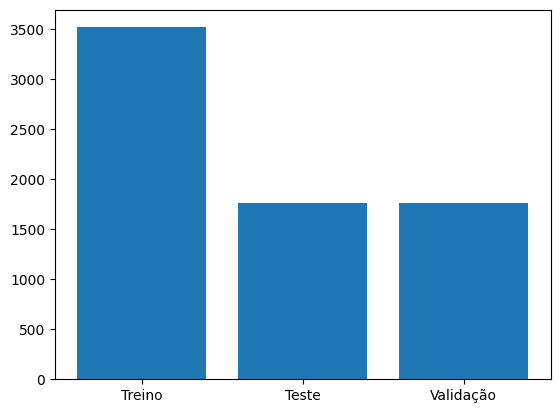

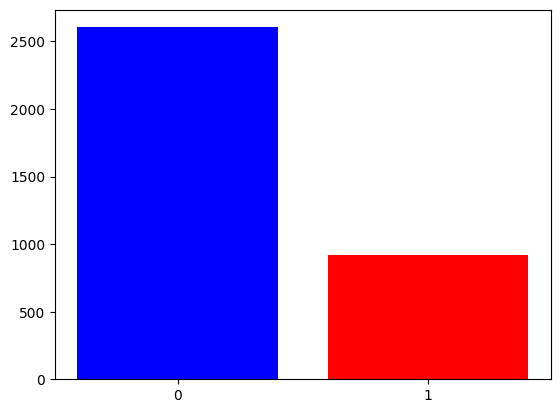

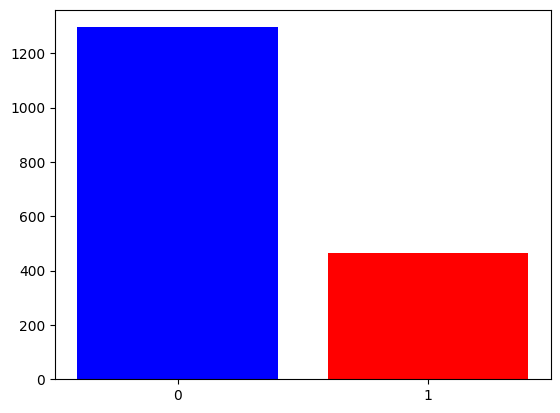

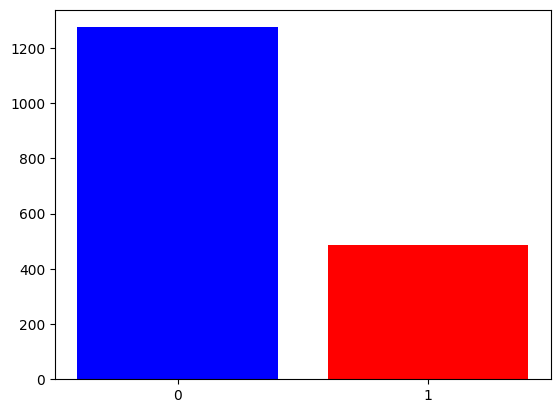

In [ ]:
# Separando os dados de treino e teste. 50% dos dados serão usados para treino e 25% para teste e 25% para validação.
# Usar K-fold para validação cruzada
porcentagem = 0.5

df_treino = df[:int(len(df)*porcentagem)]
df_test_val = df[int(len(df)*porcentagem):]

df_validacao = df_test_val[int(len(df_test_val)*porcentagem):]
df_test = df_test_val[:int(len(df_test_val)*porcentagem)]


# Plotando a quantidade de dados de treino e teste.
plt.bar(['Treino', 'Teste', 'Validação'], [df_treino.shape[0], df_test.shape[0], df_validacao.shape[0]])
plt.show()

plt.bar(df_treino['Churn'].value_counts().index, df_treino['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()

plt.bar(df_test['Churn'].value_counts().index, df_test['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()

plt.bar(df_validacao['Churn'].value_counts().index, df_validacao['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()


# Separando os dados de entrada e saída.
X_treino = df_treino.drop(columns=['Churn'])
y_treino = df_treino['Churn']

X_test = df_test.drop(columns=['Churn'])
y_test = df_test['Churn']

X_val = df_validacao.drop(columns=['Churn'])
y_val = df_validacao['Churn']


In [45]:
X_treino

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges
0,1,0,1,0,1,0,-1,1,0,1,0,0,0,0,1,29.85,29.85
1,0,0,0,0,34,1,0,1,1,0,1,0,0,0,0,56.95,1889.50
2,0,0,0,0,2,1,0,1,1,1,0,0,0,0,1,53.85,108.15
3,0,0,0,0,45,0,-1,1,1,0,1,1,0,0,0,42.30,1840.75
4,1,0,0,0,2,1,0,2,0,0,0,0,0,0,1,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,0,0,0,0,3,1,0,1,0,0,0,0,0,0,1,43.30,123.65
3517,0,0,1,0,70,1,0,2,1,1,1,1,1,1,1,109.50,7534.65
3518,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,19.45,19.45
3519,0,1,0,0,43,1,1,2,0,0,0,0,1,0,1,84.85,3645.60


In [46]:


scaler = StandardScaler()
X_train = scaler.fit_transform(X_treino)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [48]:
X_train.shape

(3521, 17)

In [ ]:
#Data Cleaning



### MLP

In [43]:
X_train

array([[ 1.0203722 , -0.43211178,  1.03733376, ...,  0.83087331,
        -1.16676003, -0.9912833 ],
       [-0.98003454, -0.43211178, -0.96400989, ..., -1.20355292,
        -0.26650732, -0.17085759],
       [-0.98003454, -0.43211178, -0.96400989, ...,  0.83087331,
        -0.36948826, -0.95673952],
       ...,
       [-0.98003454, -0.43211178, -0.96400989, ..., -1.20355292,
        -1.51224447, -0.99587149],
       [-0.98003454,  2.31421599, -0.96400989, ...,  0.83087331,
         0.66032112,  0.60388475],
       [ 1.0203722 , -0.43211178,  1.03733376, ..., -1.20355292,
        -1.50726152, -0.86572571]])

In [ ]:


def create_model(trial, input_dim):
    model = tf.keras.Sequential()
    # Camada de entrada
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    
    # Número de camadas ocultas a serem utilizadas
    n_layers = trial.suggest_int('n_layers', 1, 3)
    
    # Adicionando as camadas ocultas
    for i in range(n_layers):
        num_units = trial.suggest_int(f'n_units_{i}', 16, 128)
        model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        # Adiciona dropout se o valor sugerido for maior que 0
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.5)
        if dropout_rate > 0.0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Camada de saída para classificação binária
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Taxa de aprendizado para o otimizador
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) # Cross-entropy ou MSE
    return model

def objective_mlp(trial):
    input_dim = X_treino.shape[1]
    model = create_model(trial, input_dim)
    
    # Otimização do tamanho do batch
    batch_size = trial.suggest_int('batch_size', 16, 128)
    
    # Callback para early stopping (para interromper o treinamento se a loss de validação não melhorar)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Treinamento do modelo
    model.fit(
        X_treino, y_treino,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Avaliação do modelo no conjunto de validação (a métrica utilizada aqui é a loss)
    score = model.evaluate(X_val, y_val, verbose=0)
    val_loss = score[0]
    return val_loss

# Criação do estudo com direção de minimização (pois desejamos minimizar a loss)
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(objective_mlp, n_trials=50)
print("Melhores hiperparâmetros:", study_mlp.best_trial.params)

# Salvando os resultados do estudo em CSV e Excel

# Converte os dados dos trials para um DataFrame
df_trials = study_mlp.trials_dataframe()

# Salva em CSV
df_trials.to_csv('MLP_results.csv', index=False)
print("Resultados salvos em 'optuna_results.csv'.")

# Salva em Excel (certifique-se de ter o pacote openpyxl instalado)
df_trials.to_excel('optuna_results.xlsx', index=False)
print("Resultados salvos em 'optuna_results.xlsx'.")

# Opcional: Avaliação do modelo final no conjunto de teste utilizando os melhores hiperparâmetros
best_trial = study_mlp.best_trial
best_model = create_model(optuna.trial.FixedTrial(best_trial.params), X_treino.shape[1])
history = best_model.fit(
    X_treino, y_treino,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_trial.params.get('batch_size', 32),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)
test_score = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Loss no conjunto de teste: {test_score[0]:.4f} - Acurácia: {test_score[1]:.4f}")


2025-02-17 13:16:48.551702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'optuna' is not defined

In [ ]:
from Kantf import KAN

model = KAN([
    {'in_features': 784, 'out_features': 64, 'grid_size': 5, 'spline_order': 3, 'activation': 'silu'},
    {'in_features': 64, 'out_features': 10, 'grid_size': 5, 'spline_order': 3, 'activation': 'silu'}
])

2025-02-17 10:55:56.278223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-17 10:55:56.400139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-17 10:55:56.403114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-17 10:55:56.406021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True))

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = SparseCategoricalAccuracy(name='val_accuracy')

# Lists to store metrics for plotting
epoch_train_loss = []
epoch_val_loss = []
epoch_val_accuracy = []

for epoch in range(epochs):
    train_loss.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Existing training and validation loop here ...

    # Append metrics after each epoch
    epoch_train_loss.append(train_loss.result().numpy())
    epoch_val_loss.append(val_loss.result().numpy())
    epoch_val_accuracy.append(val_accuracy.result().numpy())

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss.result():.4f}, Validation Loss: {val_loss.result():.4f}, Validation Accuracy: {val_accuracy.result():.4f}')

NameError: name 'epochs' is not defined